Import configs

In [97]:
# Core neuromaps modules
from neuromaps.datasets import fetch_annotation, fetch_atlas
from neuromaps.transforms import (
    fsaverage_to_fslr,
    fslr_to_fslr,
    civet_to_fslr,
    mni152_to_fslr
)

from neuromaps.images import load_data, load_gifti
from neuromaps.stats import compare_images  # optional, for later correlations
from neuromaps.parcellate import Parcellater  # optional, for future analyses
from neuromaps import transforms  # optional, for direct access to transform functions

# Standard libraries
import os
from pathlib import Path
import tempfile

# Numeric and plotting
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

# correlation and spin-test
import pandas as pd
from neuromaps.nulls import alexander_bloch
from neuromaps.stats import compare_images
from statsmodels.stats.multitest import multipletests

import os

# Add Connectome Workbench to PATH for neuromaps
os.environ["PATH"] = "/Applications/Workbench/bin_macosxub:" + os.environ["PATH"]

# Test that wb_command is now visible
import subprocess
subprocess.run(["wb_command", "-version"])


Connectome Workbench
Type: Command Line Application
Version: 2.0.1
Qt Compiled Version: 6.2.3
Qt Runtime Version: 6.2.3
Commit: 150de12f4f4b94b39bec6d9133ad2e7019d2d3ef
Commit Date: 2024-10-15 17:38:41 -0500
Compiler: c++ (/Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin)
Compiler Version: 13.0.0.13000029
Compiled Debug: NO
Operating System: Apple OSX
Compiled with OpenMP: YES


CompletedProcess(args=['wb_command', '-version'], returncode=0)

In [98]:
import neuromaps
print(neuromaps.__version__)

0.0.5


## Background

In the neuromaps paper, when comparing a source map (e.g., the schizophrenia map in MNI152) to multiple target maps, they always transformed the source map into the coordinate system of the target map.

However, for our source map (hcps1200 thickness fsLR 32k) and most target maps are already in surface spaces (fsLR, fsaverage, CIVET), and sometimes even the same one. So, we just apply that same rule logically but adapt it based on resolution.

Rules:
- If target and source share the same space and density → no transformation.
- If they share the same space but different densities → transform the higher-resolution dataset to the lower-resolution one.
- If they are in different spaces (fsaverage, CIVET, MNI152) → transform the target map to the source’s space (fsLR 32k).
This keeps everything aligned to a single reference grid for correlation

Assessing the impact of coordinate system
When transforming two datasets (that is, a source and target dataset) defined in distinct coordinate spaces to a common system there are at least three options available: transform the source dataset to the system of the target, transform the target dataset to the system of the source, or transform both source and target datasets to an alternate system. If comparisons are being made across several pairs of datasets a fourth option becomes available: always transform the higher resolution dataset to the system of the lower-resolution dataset.

## Source Map

In [99]:
src_thick = fetch_annotation(source='hcps1200', desc='thickness', space='fsLR', den='32k')
ref_space = ("fsLR", "32k")
src_thick_L, src_thick_R = src_thick
src_thick

['/Users/rhekanarwastu/neuromaps-data/annotations/hcps1200/thickness/fsLR/source-hcps1200_desc-thickness_space-fsLR_den-32k_hemi-L_feature.func.gii',
 '/Users/rhekanarwastu/neuromaps-data/annotations/hcps1200/thickness/fsLR/source-hcps1200_desc-thickness_space-fsLR_den-32k_hemi-R_feature.func.gii']

## Target Maps

| #      | Category                                               | Source          | Description                | Space     | Density |
| ------ | ------------------------------------------------------ | --------------- | -------------------------- | --------- | ------- |
| **1**  | PC1 Gene Expression                                         | `abagen`        | `genepc1`                  | fsaverage | 10k     |
| **2**  | T1w/T2w Ratio                            | `hcps1200`      | `myelinmap`                | fsLR      | 32k     |
| **3**  | Developmental Expansion                                | `hill2010`      | `devexp`                   | fsLR      | 164k    |
| **4**  | Evolutionary Expansion              | `hill2010`      | `evoexp`   | fsLR      | 164k     |
| **5**  | Functional Gradient                             | `margulies2016` | `fcgradient01`  | fsLR      | 32k     |
| **6**  | Intersubject Variability                               | `mueller2013`   | `intersubjvar` | fsLR      | 164k     |
| **7**  | Cerebral Blood Flow                             | `raichle`       | `cbf`                      | fsLR      | 164k    |
| **8**  | Cerebral Blood Volume                           | `raichle`       | `cbv`                      | fsLR      | 164k    |
| **9** | Oxygen Metabolism                              | `raichle`       | `cmr02`                    | fsLR      | 164k    |
| **10** | Glucose Metabolism                            | `raichle`       | `cmrglc`                   | fsLR      | 164k    |
| **11** | Allometric Scaling (NIH) (Developmental Expansion Proxy) | `reardon2018`   | `scalingnih`               | CIVET     | 41k     |
| **12** | Allometric Scaling (PNC)                                | `reardon2018`   | `scalingpnc`               | CIVET     | 41k     |


## Transformations

In [100]:
from matplotlib import pyplot as plt
from matplotlib.cm import ScalarMappable
import matplotlib.colors as mcolors
import numpy as np
from nilearn.plotting import plot_surf
from neuromaps.datasets import ALIAS, fetch_atlas
from neuromaps.images import load_gifti
from neuromaps.transforms import _check_hemi

HEMI = dict(L='left', R='right')

def plot_surf_lateral_only(
    data, template, density, *,
    surf='inflated', hemi=None, mask_medial=True,
    colorbar='shared',          # 'none', 'each', or 'shared'
    cbar_location='right',      # 'right' or 'bottom' when colorbar='shared'
    vmin=None, vmax=None,       # shared limits. If None they are computed
    wspace=0.12, figsize=(10, 4), **kwargs
):
    """
    Lateral-only surface plot with optional shared colorbar.
    Returns (fig, cbar) where cbar can be None.
    """
    atlas = fetch_atlas(template, density, verbose=0)
    template = ALIAS.get(template, template)
    if template == 'MNI152':
        raise ValueError("Cannot plot MNI152 on the surface. Project to a surface first.")

    surf_geom = atlas[surf]
    medial = atlas['medial']

    # nilearn defaults
    opts = dict(alpha=1.0, threshold=np.spacing(1))
    opts.update(**kwargs)
    if kwargs.get('bg_map') is not None and kwargs.get('alpha') is None:
        opts['alpha'] = 'auto'

    data, hemispheres = zip(*_check_hemi(data, hemi))
    n_hemi = len(data)

    # collect data arrays to compute shared limits if needed
    arrays = []
    for img in data:
        arr = load_gifti(img).agg_data().astype('float32')
        if mask_medial:
            # we do not know hemisphere here yet, compute after
            arrays.append(arr)
        else:
            arrays.append(arr)

    if vmin is None or vmax is None:
        # robust range across hemispheres
        allvals = np.concatenate([np.ravel(a[np.isfinite(a)]) for a in arrays])
        vmin = np.nanmin(allvals) if vmin is None else vmin
        vmax = np.nanmax(allvals) if vmax is None else vmax
    opts.update(dict(vmin=vmin, vmax=vmax))

    fig, axes = plt.subplots(1, n_hemi, subplot_kw={'projection': '3d'}, figsize=figsize)
    axes = (axes,) if n_hemi == 1 else axes

    # if we will add a shared colorbar, turn per-panel colorbars off
    per_panel_cbar = (colorbar == 'each')
    if colorbar == 'shared':
        opts['colorbar'] = False
    else:
        opts['colorbar'] = per_panel_cbar

    for ax, h, img in zip(axes, hemispheres, data):
        geom = load_gifti(getattr(surf_geom, h)).agg_data()
        arr = load_gifti(img).agg_data().astype('float32')
        if mask_medial:
            med = load_gifti(getattr(medial, h)).agg_data().astype(bool)
            arr[~med] = np.nan

        ax.disable_mouse_rotation()
        plot_surf(geom, arr, hemi=HEMI[h], axes=ax, view='lateral', **opts)

    # spacing between hemispheres
    fig.subplots_adjust(wspace=wspace)

    # optional shared colorbar
    cbar = None
    if colorbar == 'shared':
        sm = ScalarMappable(norm=mcolors.Normalize(vmin=vmin, vmax=vmax),
                            cmap=opts.get('cmap', None))
        sm.set_array([])
        if cbar_location == 'right':
            cbar = fig.colorbar(sm, ax=axes, location='right', fraction=0.05, pad=0.03)
        else:  # bottom
            cbar = fig.colorbar(sm, ax=axes, location='bottom', fraction=0.05, pad=0.3)

    return fig, cbar

In [101]:
# To convert GIFTImage to PATH
def gifti_to_path(gifti_input, prefix="map", outdir=None):
    """
    Convert one or two GiftiImage objects into saved .func.gii files and return their path(s).

    Parameters
    gifti_input : GiftiImage, tuple, or list
        Either a single GiftiImage (for one hemisphere) or a (L, R) pair of GiftiImage objects.
    prefix : str
        Prefix for the output filenames (default: "map").
    outdir : str or None
        Directory to save the files. If None, creates a temporary directory.

    Returns
    path(s) : str or tuple of str
        File path(s) to the saved Gifti file(s).
        - Returns a single path if only one hemisphere is provided.
        - Returns (L_path, R_path) if both hemispheres are provided.
    """
    # Create output directory
    if outdir is None:
        outdir = tempfile.mkdtemp(prefix="neuromaps_")
    os.makedirs(outdir, exist_ok=True)

    # Case 1: single GiftiImage
    if isinstance(gifti_input, nib.gifti.gifti.GiftiImage):
        path = os.path.join(outdir, f"{prefix}.func.gii")
        nib.save(gifti_input, path)
        return path

    # Case 2: tuple/list (L, R) input
    if isinstance(gifti_input, (tuple, list)):
        # handle flexible lengths
        L_img = gifti_input[0] if len(gifti_input) > 0 else None
        R_img = gifti_input[1] if len(gifti_input) > 1 else None

        L_path = None
        R_path = None

        if L_img is not None:
            L_path = os.path.join(outdir, f"{prefix}_hemi-L.func.gii")
            nib.save(L_img, L_path)

        if R_img is not None:
            R_path = os.path.join(outdir, f"{prefix}_hemi-R.func.gii")
            nib.save(R_img, R_path)

        return (L_path, R_path)

    # Invalid input
    raise TypeError("gifti_input must be a GiftiImage or a (L, R) tuple/list of GiftiImages.")


In [102]:
colormaps = [
    "black_blue",
    "black_blue_r",
    "black_green",
    "black_green_r",
    "black_pink",
    "black_pink_r",
    "black_purple",
    "black_purple_r",
    "black_red",
    "black_red_r",
    "blue_orange",
    "blue_orange_r",
    "blue_red",
    "blue_red_r",
    "blue_transparent",
    "blue_transparent_full_alpha_range",
    "brown_blue",
    "brown_blue_r",
    "brown_cyan",
    "brown_cyan_r",
    "cold_hot",
    "cold_hot_r",
    "cold_white_hot",
    "cold_white_hot_r",
    "cyan_copper",
    "cyan_copper_r",
    "cyan_orange",
    "cyan_orange_r",
    "green_transparent",
    "green_transparent_full_alpha_range",
    "hot_black_bone",
    "hot_black_bone_r",
    "hot_white_bone",
    "hot_white_bone_r",
    "ocean_hot",
    "ocean_hot_r",
    "purple_blue",
    "purple_blue_r",
    "purple_green",
    "purple_green_r",
    "red_transparent",
    "red_transparent_full_alpha_range",
    "roy_big_bl",
    "videen_style"
]

In [103]:
colormaps2 = [
    "Accent", "Blues", "BrBG", "BuGn", "BuPu",
    "CMRmap", "Dark2", "GnBu", "Greens", "Greys",
    "OrRd", "Oranges", "PRGn", "Paired", "Pastel1",
    "Pastel2", "PiYG", "PuBu", "PuBuGn", "PuOr",
    "PuRd", "Purples", "RdBu", "RdGy", "RdPu",
    "RdYlBu", "RdYlGn", "Reds", "Set1", "Set2",
    "Set3", "Spectral", "Wistia", "YlGn", "YlGnBu",
    "YlOrBr", "YlOrRd", "afmhot", "autumn", "binary",
    "bone", "brg", "bwr", "cool", "coolwarm",
    "copper", "cubehelix", "flag", "gist_earth", "gist_gray",
    "gist_heat", "gist_ncar", "gist_rainbow", "gist_stern", "gist_yarg",
    "gnuplot", "gnuplot2", "gray", "hot", "hsv",
    "jet", "nipy_spectral", "ocean", "pink", "prism",
    "rainbow", "seismic", "spring", "summer", "tab10",
    "tab20", "tab20b", "tab20c", "terrain", "winter"
]

### PC1 gene expression

In [104]:
genepc1 = fetch_annotation(source='abagen', desc='genepc1', space='fsaverage', den='10k')
genepc1_fsLR32k = fsaverage_to_fslr(genepc1, target_density='32k')


/var/folders/v2/ws2f5s354c13rp1pbqh8l04w0000gn/T/ipykernel_28494/35654189.py:76: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plot_surf(geom, arr, hemi=HEMI[h], axes=ax, view='lateral', **opts)


Text(0.5, 0.98, 'PC1 fsLR 32k')

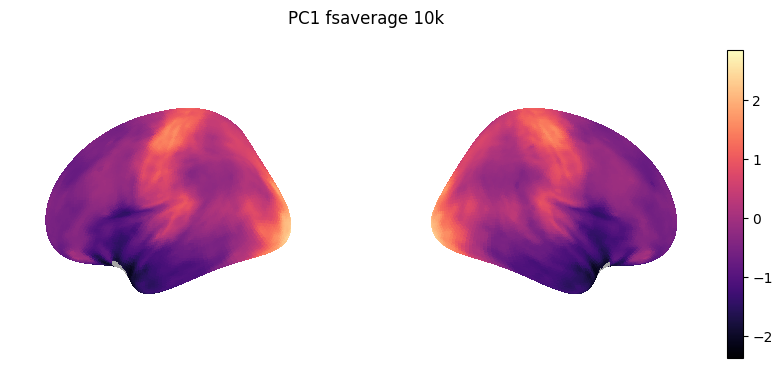

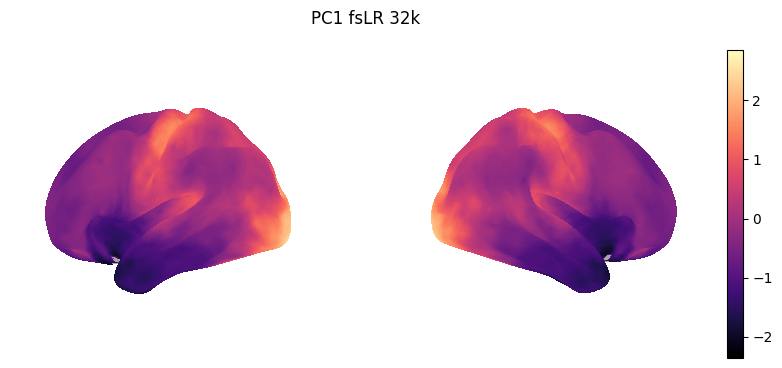

In [105]:
# before
fig1, cbar1 = plot_surf_lateral_only(
    genepc1, template='fsaverage', density='10k',
    cmap='magma', colorbar='shared', cbar_location='right', wspace=0.18
)
fig1.suptitle('PC1 fsaverage 10k', y=0.98)

# after
genepc1_fsLR32k_path = gifti_to_path(genepc1_fsLR32k) # change the gifti to path

fig2, cbar2 = plot_surf_lateral_only(
    genepc1_fsLR32k_path, template='fsLR', density='32k',
    cmap='magma', colorbar='shared', cbar_location='right', wspace=0.18
)
fig2.suptitle('PC1 fsLR 32k', y=0.98)

### T1w/T2w ratio (Myelin map)

In [106]:
myelinmap = fetch_annotation(source='hcps1200', desc='myelinmap', space='fsLR', den='32k')
myelinmap_fsLR32k = myelinmap  # already in target space
myelinmap_fsLR32k_L, myelinmap_fsLR32k_R = myelinmap_fsLR32k
myelinmap_fsLR32k

['/Users/rhekanarwastu/neuromaps-data/annotations/hcps1200/myelinmap/fsLR/source-hcps1200_desc-myelinmap_space-fsLR_den-32k_hemi-L_feature.func.gii',
 '/Users/rhekanarwastu/neuromaps-data/annotations/hcps1200/myelinmap/fsLR/source-hcps1200_desc-myelinmap_space-fsLR_den-32k_hemi-R_feature.func.gii']

/var/folders/v2/ws2f5s354c13rp1pbqh8l04w0000gn/T/ipykernel_28494/35654189.py:76: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plot_surf(geom, arr, hemi=HEMI[h], axes=ax, view='lateral', **opts)


Text(0.5, 0.98, 'T1w/T2w ratio fsLR 32k')

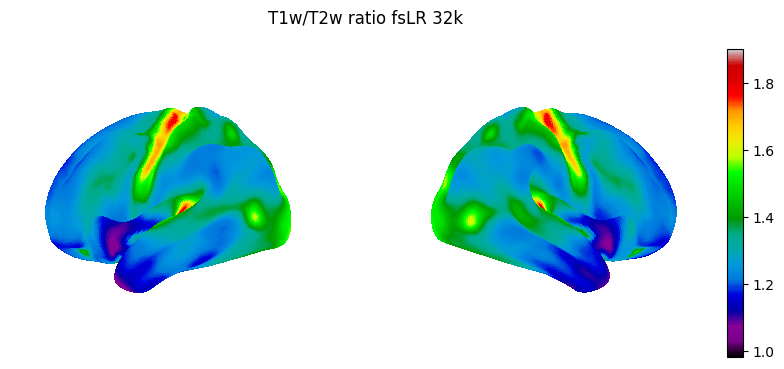

In [107]:
fig3, cbar3 = plot_surf_lateral_only(
    myelinmap_fsLR32k, template='fsLR', density='32k',
    cmap='nipy_spectral', colorbar='shared', cbar_location='right', wspace=0.18,
    vmin=0.98, vmax=1.9
)
fig3.suptitle('T1w/T2w ratio fsLR 32k', y=0.98)

### Developmental expansion (PNC)



In [108]:
devexp = fetch_annotation(source='hill2010', desc='devexp', space='fsLR', den='164k')
devexp

'/Users/rhekanarwastu/neuromaps-data/annotations/hill2010/devexp/fsLR/source-hill2010_desc-devexp_space-fsLR_den-164k_hemi-R_feature.func.gii'

Because hill2010/devexp only exists for the right hemisphere we transformed it like this:

In [109]:
devexp = fetch_annotation(source='hill2010', desc='devexp', space='fsLR', den='164k')
devexp_fsLR = fslr_to_fslr(devexp, '32k', hemi='R')
devexp_rh_32k, = devexp_fsLR

# Check data shape
print(devexp_rh_32k.agg_data().shape)
devexp_fsLR

(32492,)


(<nibabel.gifti.gifti.GiftiImage at 0x46efe70b0>,)

/var/folders/v2/ws2f5s354c13rp1pbqh8l04w0000gn/T/ipykernel_28494/35654189.py:76: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plot_surf(geom, arr, hemi=HEMI[h], axes=ax, view='lateral', **opts)


Text(0.5, 0.98, 'Developmental expansion fsLR 32k')

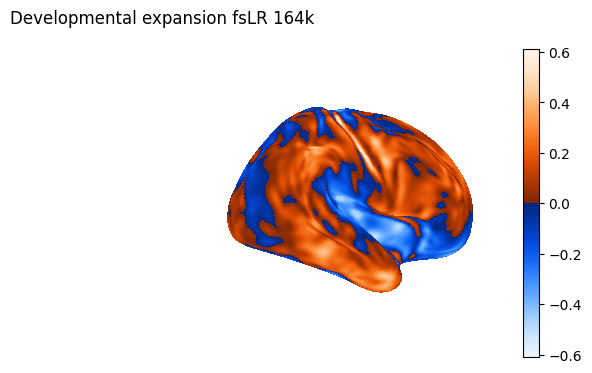

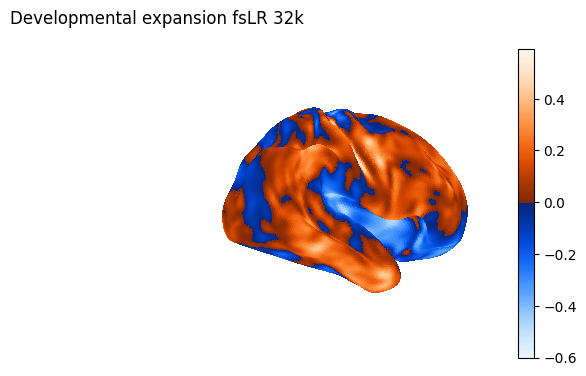

In [110]:
# before
fig5, cbar5 = plot_surf_lateral_only(
    devexp, template='fsLR', density='164k', hemi='R',
    cmap='blue_orange', colorbar='shared', cbar_location='right', wspace=0.18,
    vmin=-0.61, vmax=0.61
)
fig5.suptitle('Developmental expansion fsLR 164k', y=0.98)

# after
devexp_fsLR_path = gifti_to_path(devexp_fsLR) # change the gifti to path

fig6, cbar6 = plot_surf_lateral_only(
    devexp_fsLR_path, template='fsLR', density='32k', hemi='R',
    cmap='blue_orange', colorbar='shared', cbar_location='right', wspace=0.18,
    vmin=-0.6, vmax=0.59
)
fig6.suptitle('Developmental expansion fsLR 32k', y=0.98)

### Evolutionary expansion



hill2010/evoexp also only exists for the right hemisphere.

In [111]:
evoexp = fetch_annotation(source='hill2010', desc='evoexp', space='fsLR', den='164k', hemi='R')
evoexp_fsLR32k = fslr_to_fslr(evoexp, target_density='32k', hemi='R')
evoexp_rh_32k, = evoexp_fsLR32k

# Check data shape
print(evoexp_rh_32k.agg_data().shape)

(32492,)


/var/folders/v2/ws2f5s354c13rp1pbqh8l04w0000gn/T/ipykernel_28494/35654189.py:76: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plot_surf(geom, arr, hemi=HEMI[h], axes=ax, view='lateral', **opts)


Text(0.5, 0.98, 'Evolutionary expansion fsLR 32k')

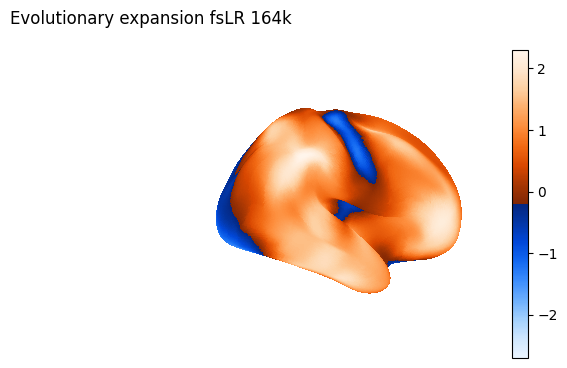

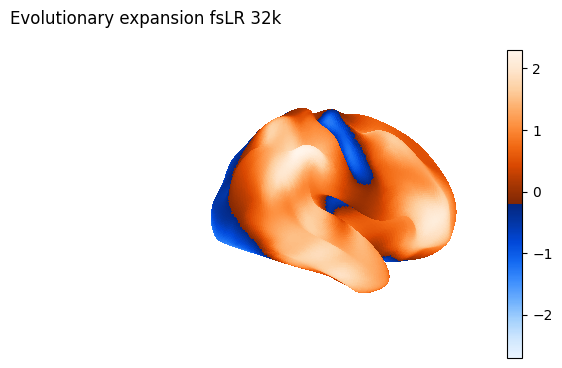

In [112]:
# before
fig7, cbar57 = plot_surf_lateral_only(
    evoexp, template='fsLR', density='164k', hemi='R',
    cmap='blue_orange', colorbar='shared', cbar_location='right', wspace=0.18,
    vmin=-2.7, vmax=2.3
)
fig7.suptitle('Evolutionary expansion fsLR 164k', y=0.98)

# after
evoexp_fsLR32k_path = gifti_to_path(evoexp_fsLR32k)
fig8, cbar8 = plot_surf_lateral_only(
    evoexp_fsLR32k_path, template='fsLR', density='32k', hemi='R',
    cmap='blue_orange', colorbar='shared', cbar_location='right', wspace=0.18,
    vmin=-2.7, vmax=2.3
)
fig8.suptitle('Evolutionary expansion fsLR 32k', y=0.98)

### Functional gradient (FC grad 1)



In [113]:
gradient_pc1 = fetch_annotation(source='margulies2016', desc='fcgradient01', space='fsLR', den='32k')
gradient_pc1_fsLR32k = gradient_pc1
gradient_pc1_fsLR32k_L, gradient_pc1_fsLR32k_R = gradient_pc1_fsLR32k

/var/folders/v2/ws2f5s354c13rp1pbqh8l04w0000gn/T/ipykernel_28494/35654189.py:76: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plot_surf(geom, arr, hemi=HEMI[h], axes=ax, view='lateral', **opts)


Text(0.5, 0.98, 'Functional gradient fsLR 32k')

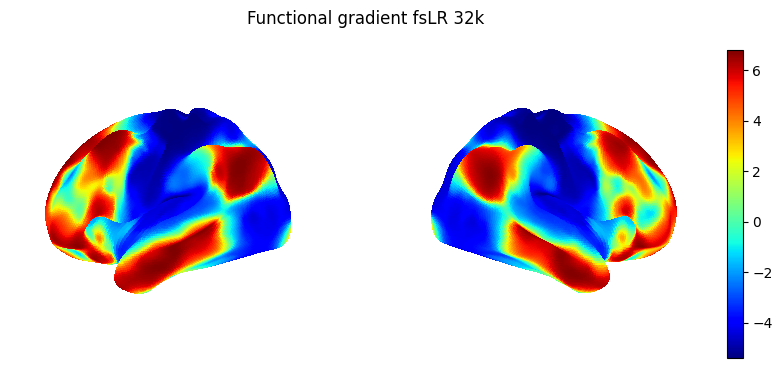

In [114]:
fig9, cbar9 = plot_surf_lateral_only(
    gradient_pc1_fsLR32k, template='fsLR', density='32k',
    cmap='jet', colorbar='shared', cbar_location='right', wspace=0.18,
    vmin=-5.4, vmax=6.8
)
fig9.suptitle('Functional gradient fsLR 32k', y=0.98)

## Downsample from 164k → 32k

### Intersubject variability

In [115]:
isv = fetch_annotation(source='mueller2013', desc='intersubjvar', space='fsLR', den='164k')
isv_fsLR32k = fslr_to_fslr(isv, target_density='32k')
isv_fsLR32k_L, isv_fsLR32k_R = isv_fsLR32k

/var/folders/v2/ws2f5s354c13rp1pbqh8l04w0000gn/T/ipykernel_28494/35654189.py:76: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plot_surf(geom, arr, hemi=HEMI[h], axes=ax, view='lateral', **opts)


Text(0.5, 0.98, 'Intersubject variability fsLR 32k')

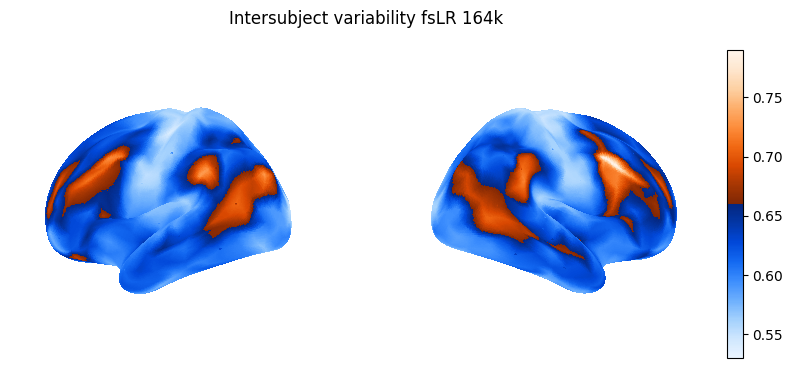

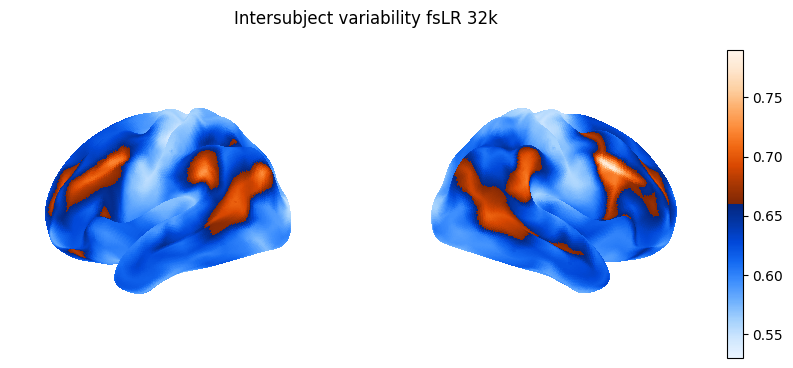

In [116]:
# before
fig10, cbar10 = plot_surf_lateral_only(
    isv, template='fsLR', density='164k',
    cmap='blue_orange', colorbar='shared', cbar_location='right', wspace=0.18,
    vmin=0.53, vmax=0.79
)
fig10.suptitle('Intersubject variability fsLR 164k', y=0.98)

# after
isv_fsLR32k_path = gifti_to_path(isv_fsLR32k)
fig11, cbar11 = plot_surf_lateral_only(
    isv_fsLR32k_path, template='fsLR', density='32k',
    cmap='blue_orange', colorbar='shared', cbar_location='right', wspace=0.18,
    vmin=0.53, vmax=0.79
)
fig11.suptitle('Intersubject variability fsLR 32k', y=0.98)

### Cerebral blood flow (CBF)



In [117]:
cbf = fetch_annotation(source='raichle', desc='cbf', space='fsLR', den='164k')
cbf_fsLR32k = fslr_to_fslr(cbf, target_density='32k')
cbf_fsLR32k_L, cbf_fsLR32k_R = cbf_fsLR32k

/var/folders/v2/ws2f5s354c13rp1pbqh8l04w0000gn/T/ipykernel_28494/35654189.py:76: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plot_surf(geom, arr, hemi=HEMI[h], axes=ax, view='lateral', **opts)


Text(0.5, 0.98, 'Cerebral blood flow fsLR 32k')

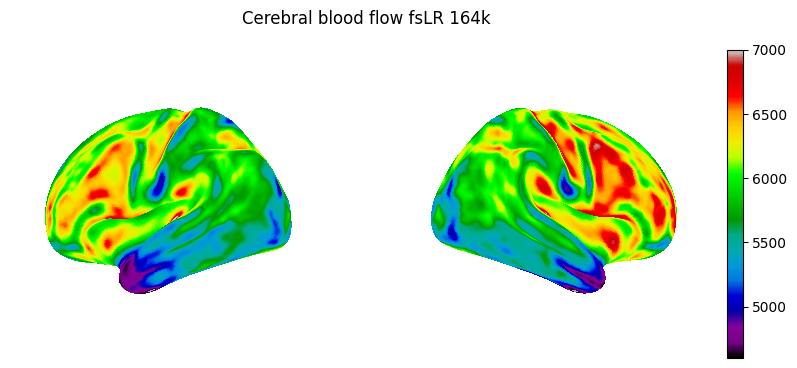

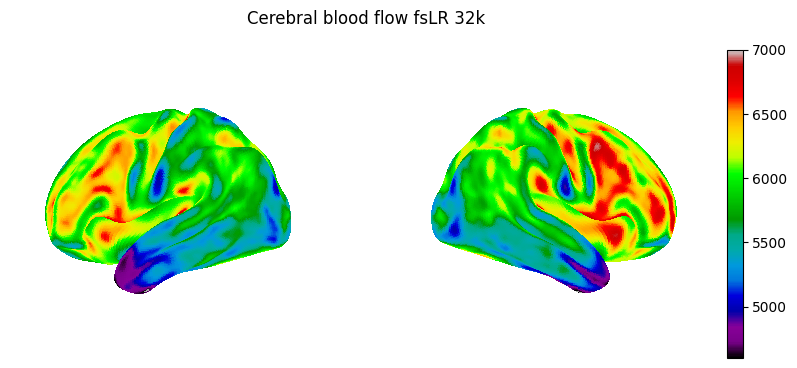

In [118]:
# before
fig12, cbar12 = plot_surf_lateral_only(
    cbf, template='fsLR', density='164k',
    cmap='nipy_spectral', colorbar='shared', cbar_location='right', wspace=0.18,
    vmin=4600, vmax=7000
)
fig12.suptitle('Cerebral blood flow fsLR 164k', y=0.98)

# after
cbf_fsLR32k_path = gifti_to_path(cbf_fsLR32k)

fig13, cbar13 = plot_surf_lateral_only(
    cbf_fsLR32k_path, template='fsLR', density='32k',
    cmap='nipy_spectral', colorbar='shared', cbar_location='right', wspace=0.18,
    vmin=4600, vmax=7000
)
fig13.suptitle('Cerebral blood flow fsLR 32k', y=0.98)

### Cerebral blood volume (CBV)



In [119]:
cbv = fetch_annotation(source='raichle', desc='cbv', space='fsLR', den='164k')
cbv_fsLR32k = fslr_to_fslr(cbv, target_density='32k')
cbv_fsLR32k_L, cbv_fsLR32k_R = cbv_fsLR32k

/var/folders/v2/ws2f5s354c13rp1pbqh8l04w0000gn/T/ipykernel_28494/35654189.py:76: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plot_surf(geom, arr, hemi=HEMI[h], axes=ax, view='lateral', **opts)


Text(0.5, 0.98, 'Cerebral blood volume fsLR 32k')

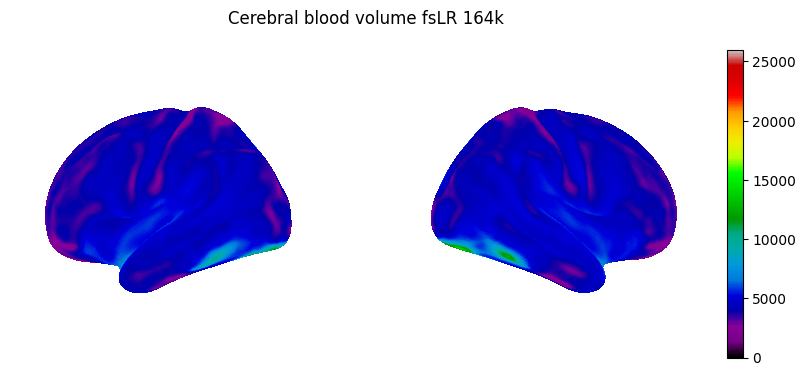

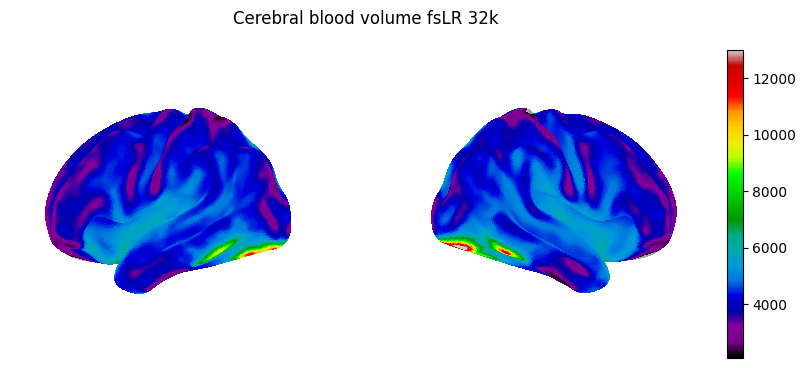

In [120]:
# before
fig14, cbar14 = plot_surf_lateral_only(
    cbv, template='fsLR', density='164k',
    cmap='nipy_spectral', colorbar='shared', cbar_location='right', wspace=0.18,
    vmin=0, vmax=26000
)
fig14.suptitle('Cerebral blood volume fsLR 164k', y=0.98)

# after 
cbv_fsLR32k_path = gifti_to_path(cbv_fsLR32k)
fig15, cbar15 = plot_surf_lateral_only(
    cbv_fsLR32k_path, template='fsLR', density='32k',
    cmap='nipy_spectral', colorbar='shared', cbar_location='right', wspace=0.18,
    vmin=2100, vmax=13000
)
fig15.suptitle('Cerebral blood volume fsLR 32k', y=0.98)

### Oxygen metabolism (CMRO2)



In [121]:
cmro2 = fetch_annotation(source='raichle', desc='cmr02', space='fsLR', den='164k')
cmro2_fsLR32k = fslr_to_fslr(cmro2, target_density='32k')
cmro2_fsLR32k_L, cmro2_fsLR32k_R = cmro2_fsLR32k

/var/folders/v2/ws2f5s354c13rp1pbqh8l04w0000gn/T/ipykernel_28494/35654189.py:76: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plot_surf(geom, arr, hemi=HEMI[h], axes=ax, view='lateral', **opts)


Text(0.5, 0.98, 'Oxygen metabolism fsLR 32k')

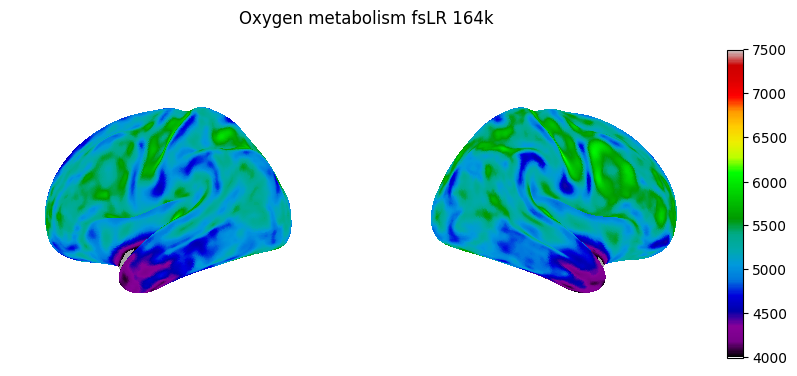

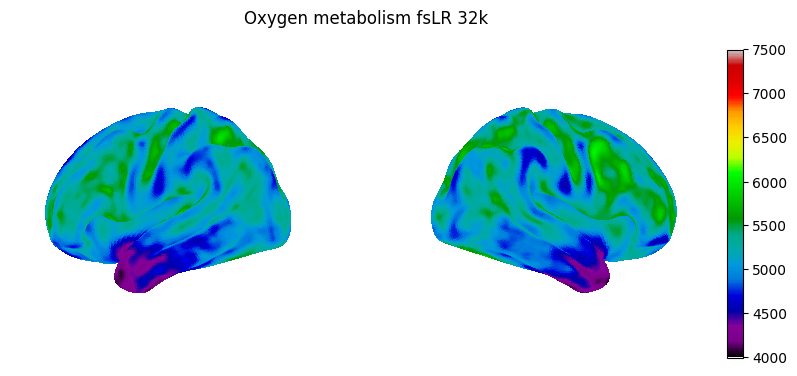

In [122]:
# before
fig16, cbar16 = plot_surf_lateral_only(
    cmro2, template='fsLR', density='164k',
    cmap='nipy_spectral', colorbar='shared', cbar_location='right', wspace=0.18,
    vmin=4000, vmax=7500
)
fig16.suptitle('Oxygen metabolism fsLR 164k', y=0.98)

# after
cmro2_fsLR32k_path = gifti_to_path(cmro2_fsLR32k)
fig17, cbar17 = plot_surf_lateral_only(
    cmro2_fsLR32k_path, template='fsLR', density='32k',
    cmap='nipy_spectral', colorbar='shared', cbar_location='right', wspace=0.18,
    vmin=4000, vmax=7500
)
fig17.suptitle('Oxygen metabolism fsLR 32k', y=0.98)

### Glucose metabolism (CMRGlu)



In [123]:
cmrglc = fetch_annotation(source='raichle', desc='cmrglc', space='fsLR', den='164k')
cmrglc_fsLR32k = fslr_to_fslr(cmrglc, target_density='32k')
cmrglc_fsLR32k_L, cmrglc_fsLR32k_R = cmrglc_fsLR32k

/var/folders/v2/ws2f5s354c13rp1pbqh8l04w0000gn/T/ipykernel_28494/35654189.py:76: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plot_surf(geom, arr, hemi=HEMI[h], axes=ax, view='lateral', **opts)


Text(0.5, 0.98, 'Glucose metabolism fsLR 32k')

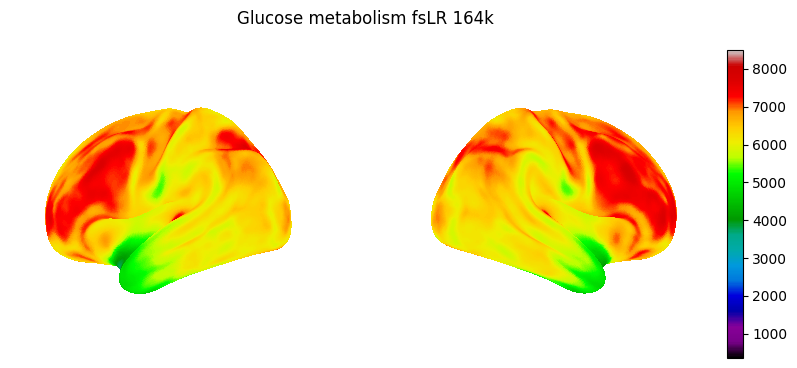

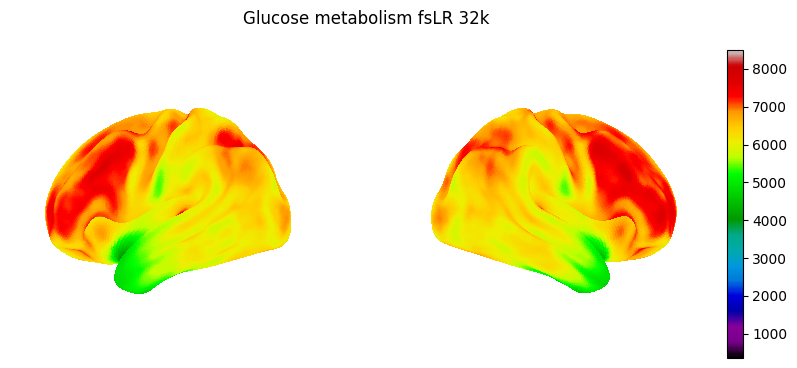

In [124]:
# before
fig18, cbar18 = plot_surf_lateral_only(
    cmrglc, template='fsLR', density='164k',
    cmap='nipy_spectral', colorbar='shared', cbar_location='right', wspace=0.18,
    vmin=360, vmax=8500
)
fig18.suptitle('Glucose metabolism fsLR 164k', y=0.98)

# after
cmrglc_fsLR32k_path = gifti_to_path(cmrglc_fsLR32k)
fig19, cbar19 = plot_surf_lateral_only(
    cmrglc_fsLR32k_path, template='fsLR', density='32k',
    cmap='nipy_spectral', colorbar='shared', cbar_location='right', wspace=0.18,
    vmin=360, vmax=8500
)
fig19.suptitle('Glucose metabolism fsLR 32k', y=0.98)

## CIVET → fsLR 32k

### Allometric scaling (NIH)



In [125]:
scalingnih = fetch_annotation(source='reardon2018', desc='scalingnih', space='civet', den='41k')
scalingnih_fsLR32k = civet_to_fslr(scalingnih, target_density='32k')
scalingnih_fsLR32k_L, scalingnih_fsLR32k_R = scalingnih_fsLR32k
print(scalingnih_fsLR32k_L.agg_data())

[1.1884882  0.81385535 0.8314943  ... 1.1848563  1.1839551  1.1833417 ]


/var/folders/v2/ws2f5s354c13rp1pbqh8l04w0000gn/T/ipykernel_28494/35654189.py:76: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plot_surf(geom, arr, hemi=HEMI[h], axes=ax, view='lateral', **opts)


Text(0.5, 0.98, 'Allometric scaling (NIH) fsLR 32k')

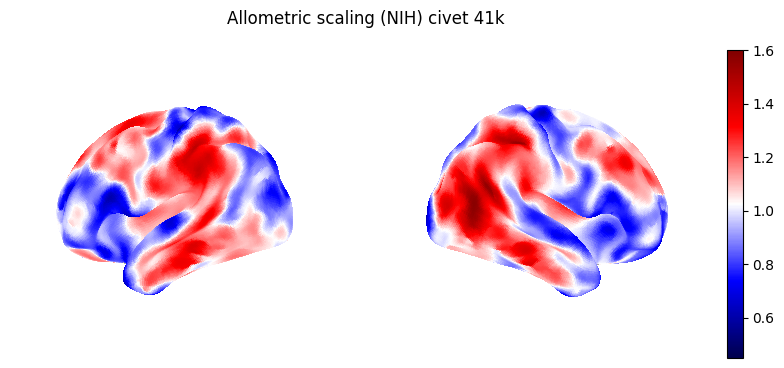

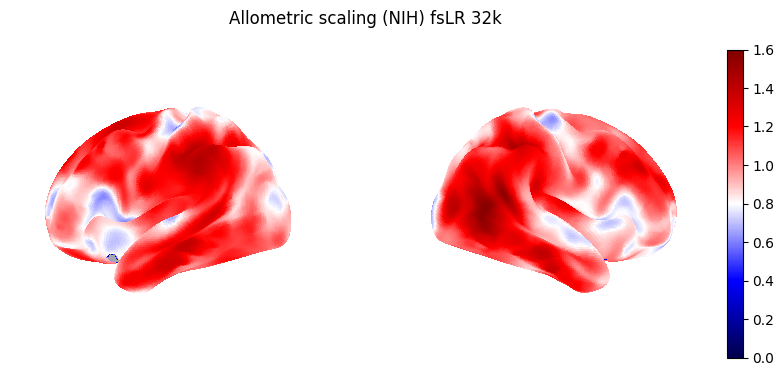

In [126]:
# before
fig20, cbar20 = plot_surf_lateral_only(
    scalingnih, template='civet', density='41k',
    cmap='seismic', colorbar='shared', cbar_location='right', wspace=0.18,
    vmin=0.45, vmax=1.6
)
fig20.suptitle('Allometric scaling (NIH) civet 41k', y=0.98)

# after
scalingnih_fsLR32k_path = gifti_to_path(scalingnih_fsLR32k)
fig21, cbar21 = plot_surf_lateral_only(
    scalingnih_fsLR32k_path, template='fsLR', density='32k',
    cmap='seismic', colorbar='shared', cbar_location='right', wspace=0.18,
    vmin=0, vmax=1.6
)
fig21.suptitle('Allometric scaling (NIH) fsLR 32k', y=0.98)

### Allometric scaling (PNC)



In [127]:
scalingpnc = fetch_annotation(source='reardon2018', desc='scalingpnc', space='civet', den='41k')
scalingpnc_fsLR32k = civet_to_fslr(scalingpnc, target_density='32k')
scalingpnc_fsLR32k_L, scalingpnc_fsLR32k_R = scalingpnc_fsLR32k

/var/folders/v2/ws2f5s354c13rp1pbqh8l04w0000gn/T/ipykernel_28494/35654189.py:76: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plot_surf(geom, arr, hemi=HEMI[h], axes=ax, view='lateral', **opts)


Text(0.5, 0.98, 'Allometric scaling (PNC) fsLR 32k')

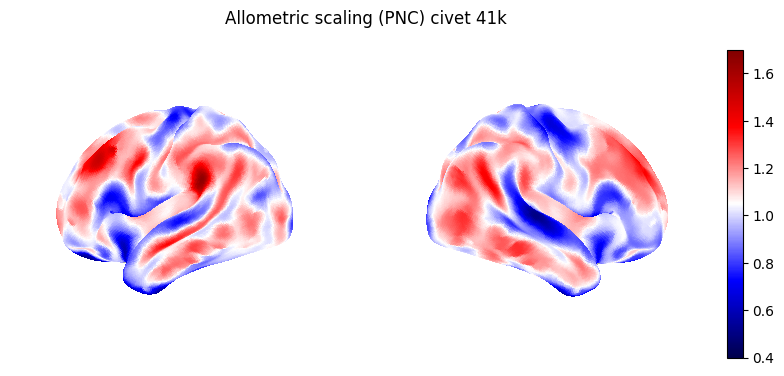

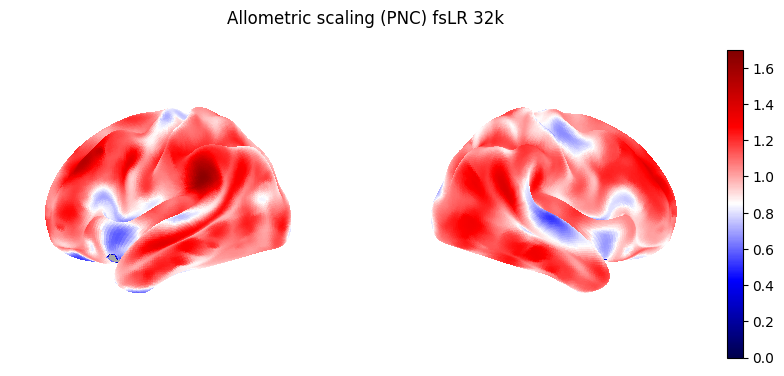

In [128]:
# before
fig22, cbar22 = plot_surf_lateral_only(
    scalingpnc, template='civet', density='41k',
    cmap='seismic', colorbar='shared', cbar_location='right', wspace=0.18,
    vmin=0.4, vmax=1.7
)
fig22.suptitle('Allometric scaling (PNC) civet 41k', y=0.98)

# after
scalingpnc_fsLR32k_path = gifti_to_path(scalingpnc_fsLR32k)
fig23, cbar23 = plot_surf_lateral_only(
    scalingpnc_fsLR32k_path, template='fsLR', density='32k',
    cmap='seismic', colorbar='shared', cbar_location='right', wspace=0.18,
    vmin=0, vmax=1.7
)
fig23.suptitle('Allometric scaling (PNC) fsLR 32k', y=0.98)

## Correlations & Spin Test

#### Correlations

After transforming all target maps into the same cortical surface space (fsLR-32k), the next step is to quantify how strongly each target map’s spatial pattern aligns with the average cortical thickness pattern from the Human Connectome Project (HCP S1200 dataset).

We measure this alignment using Pearson’s correlation coefficient (r) across corresponding cortical vertices.

This tells us whether regions that are thicker or thinner in the healthy human cortex also tend to show higher or lower values in each biological or functional brain feature (e.g., myelination, metabolism, or gene expression):
- r > 0 → Regions that are thicker tend to have higher values in the target map. Example: a positive r with developmental expansion would indicate that thicker cortex corresponds to regions that expanded more during development.
- r < 0 → Regions that are thicker tend to have lower values in the target map.
For instance, a negative r with myelin means thicker cortex is found in less-myelinated areas.
- r ≈ 0 → No clear spatial relationship between cortical thickness and the target feature.

#### Spin Test

Brain maps aren’t random: neighboring vertices tend to have similar values.

What it does:
- It generates thousands of rotated versions (“spins”) of the source cortical map on the sphere.
- Each spin keeps the map’s smooth, spatially autocorrelated structure but moves its pattern to new cortical locations.
- For each rotated map, you recompute the correlation with the target.

You get a null distribution of correlations that would occur purely by chance under the same spatial smoothness. The empirical correlation is then compared to this null distribution to compute a spin p-value (Pspin). A small Pspin (e.g., 0.001) means your observed alignment is stronger than what 999 of 1000 random spatial rotations produce → statistically significant after accounting for spatial autocorrelation.


In [129]:
# HELPER FUNCTIONS

def data1d(x):
    """Path or GiftiImage -> 1D array."""
    img = x if isinstance(x, nib.gifti.gifti.GiftiImage) else nib.load(x)
    return np.asarray(img.agg_data()).squeeze()

def lr_arrays(entry, nL=32492, nR=32492, fill='nan', L_mean=None):
    """
    Normalize an entry into (L, R) arrays.
    - entry can be (L, R) objects or paths
    - or a single-hemi object/path (we detect by user input; pass None for missing)
    - fill strategy controls what to do if only one hemisphere is provided:
        'nan'    → pad missing hemi with NaNs
        'mirror' → copy the existing hemi to both sides
        'mean'   → fill missing hemi with provided L_mean array
    """
    # Case 1: both hemispheres provided
    if isinstance(entry, (tuple, list)) and len(entry) == 2:
        L, R = entry
        L_arr = data1d(L) if L is not None else np.full(nL, np.nan)
        R_arr = data1d(R) if R is not None else np.full(nR, np.nan)
        return L_arr, R_arr

    # Case 2: single hemisphere only
    arr = data1d(entry)

    if fill == 'mirror':
        # Duplicate the same array for both hemispheres
        return arr.copy(), arr.copy()

    else:  # default = NaN padding
        return np.full(nL, np.nan), arr


In [130]:
# LIST OF MAPS

maps = {
    "source_thickness": src_thick,         # list of paths [L_path, R_path]
    "genepc1":           genepc1_fsLR32k,
    "myelin":            myelinmap_fsLR32k,
    "devexp":            (None, devexp_rh_32k),
    "evoexp":            (None, evoexp_rh_32k),
    "gradient_pc1":      gradient_pc1_fsLR32k,
    "isv":               isv_fsLR32k,
    "cbf":               cbf_fsLR32k,
    "cbv":               cbv_fsLR32k,
    "cmro2":             cmro2_fsLR32k,
    "cmrglc":            cmrglc_fsLR32k,
    "scalingnih":        scalingnih_fsLR32k,
    "scalingpnc":        scalingpnc_fsLR32k,
}

In [131]:
N_PERM = 1000
SEED = 42

# Load all L/R arrays per map into hemisphere-wise dicts
arrays_L, arrays_R = {}, {}
for name, entry in maps.items():
    L_arr, R_arr = lr_arrays(entry)
    arrays_L[name], arrays_R[name] = L_arr, R_arr

# Make whole-cortex vectors by concatenating L and R
vectors = {name: np.concatenate([arrays_L[name], arrays_R[name]]) for name in arrays_L}

# Get the source map
src_name = "source_thickness"
src_vec = vectors[src_name]


# Generate spin-based nulls on the source map
nulls = alexander_bloch(
    data=src_thick,     # data to spin
    atlas='fsLR',       # which atlas space we're spinning on
    density='32k',      # resolution
    n_perm=N_PERM,      # number of rotations
    seed=SEED           # reproducibility
)

# Check if rows (= vertices) of nulls must match length of src_vec
assert nulls.shape[0] == src_vec.size, f"nulls rows = {nulls.shape[0]}, expected {src_vec.size}" # 64984
assert nulls.shape[1] == N_PERM, f"nulls columns = {nulls.shape[1]}, expected {N_PERM}" # 1000


In [132]:
# --- main loop ---
rows = []

for name, tgt_vec in vectors.items():
    if name == src_name:
        continue

    # observed correlation
    r_obs = compare_images(src_vec, tgt_vec, metric="pearsonr", ignore_zero=True)

    # null correlations: iterate over columns now
    r_null = np.array([
        compare_images(nulls[:, i], tgt_vec, metric="pearsonr", ignore_zero=True)
        for i in range(N_PERM)
    ])

    # two-tailed p-value
    p_spin = (np.sum(np.abs(r_null) >= np.abs(r_obs)) + 1) / (N_PERM + 1)

    rows.append({"map": name, "r": float(r_obs), "p_spin": float(p_spin)})

df = pd.DataFrame(rows).sort_values("p_spin")

## FDR Correction

Identifies which correlations are truly significant.

What it does:
- Adjusts the p-values so that, across all 12 tests, the expected proportion of false discoveries among those declared significant stays ≤ 5%.
- Uses the Benjamini–Hochberg (BH) procedure:
    1. Sort p values from smallest → largest.
    2. Compare each to its rank-scaled threshold.
    3. Mark as significant if p ≤ threshold.

In [133]:
# --- FDR correction with alpha = 0.05 (standard)---
reject, p_fdr, _, _ = multipletests(df["p_spin"].values, alpha=0.05, method="fdr_bh")
df["p_fdr"] = p_fdr
df["sig_fdr"] = reject

df.sort_values("p_fdr")

,map,r,p_spin,p_fdr,sig_fdr
0,genepc1,-0.697060,0.000999,0.005994,True
1,myelin,-0.557634,0.000999,0.005994,True
8,cmro2,-0.461402,0.002997,0.011988,True
4,gradient_pc1,0.356469,0.028971,0.083916,False
9,cmrglc,-0.397825,0.034965,0.083916,False
5,isv,0.273599,0.100899,0.182817,False
6,cbf,-0.269239,0.118881,0.182817,False
3,evoexp,0.314704,0.121878,0.182817,False
10,scalingnih,0.135482,0.321678,0.428904,False
7,cbv,-0.078511,0.579421,0.695305,False


## Interpretation of Significant Relationships

1. `genepc1` (-0.70): 
    - The negative correlation means regions with greater cortical thickness tend to have lower genepc1 values.
    - So, thicker regions (like frontal/temporal association areas) have distinct molecular expression profiles compared to thinner, early-developing sensory regions.
2. `myelin` (-0.56): 
    - The myelin map shows how much myelin (fatty insulation) different cortical regions have
    - Negative correlation → Thicker cortex = less myelinated.
3. `cmro2` (−0.46):
    - CMRO₂ = cerebral metabolic rate of oxygen consumption.
    - Negative correlation → Thicker regions have lower baseline metabolic activity.